# Import

In [0]:
import math
import numpy as np
import tensorflow as tf
import keras as keras
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [0]:
#https://github.com/pkmital/tensorflow_tutorials/blob/master/python/libs/utils.py
def montage(images):  
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones(
        (images.shape[1] * n_plots + n_plots + 1,
         images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter, ...]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w, :] = this_img
    return m

# Loading data , Data preprocessing

In [0]:
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = tf.keras.datasets.mnist.load_data()

In [0]:
print("Shape of X_train" + str(X_train_orig.shape))
m = len(X_train_orig)
print("No. of training examples = " +str(m))

Shape of X_train(60000, 28, 28)
No. of training examples = 60000


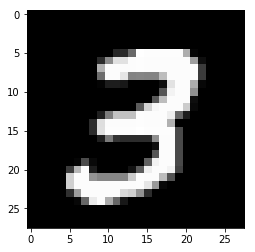

In [0]:
index = 7
plt.imshow(X_train_orig[index],cmap='gray')

In [0]:
X_train = X_train_orig.reshape(60000,28,28,1)
#X_train = X_train_orig.reshape(50000,32,32,3)
X_train = (X_train - 127.5) / 127.5

X_train.shape

(60000, 28, 28, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


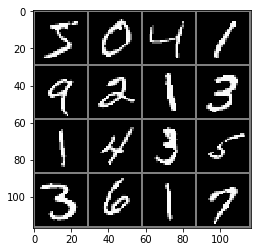

In [0]:
plt.imshow(montage(X_train[:16,:,:,:]))

# Reset

In [0]:
tf.reset_default_graph()

# Placeholders *and* Weights

In [0]:
def create_placeholder(X_train,mini_batch_size):
    
    X_train = tf.placeholder(name = "X_train" , shape = [mini_batch_size,X_train.shape[1],X_train.shape[2],X_train.shape[3]] , dtype =tf.float32 )
    Z=tf.placeholder(tf.float32,shape=[mini_batch_size,100])
    
    return X_train,Z

In [0]:
with tf.variable_scope('Gen',reuse=tf.AUTO_REUSE):
    g_W6 = tf.get_variable(name='W6_gen',initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=12), shape=[100,150],trainable=True)
    #g_b6 = tf.get_variable(name="b6_gen",trainable=True,dtype=tf.dtypes.float32)
    g_W5 = tf.get_variable(name='W5_gen',initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=12), shape=[150,49],trainable=True)
    #g_b5 = tf.get_variable(name="b5_gen",trainable=True,dtype=tf.dtypes.float32)
    g_W4 = tf.get_variable(name='W4_gen',initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=12), shape=[3,3,7,1],trainable=True)
    g_b4 = tf.get_variable(name="b4_gen", initializer=tf.zeros([7]),trainable=True)
    g_W3 = tf.get_variable(name='W3_gen',initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=12), shape=[3,3,5,7],trainable=True)
    g_b3 = tf.get_variable(name="b3_gen", initializer=tf.zeros([5]),trainable=True)
    
    g_W2 = tf.get_variable(name='W2_gen',initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=12), shape=[5,5,3,5],trainable=True)
    g_b2 = tf.get_variable(name="b2_gen", initializer=tf.zeros([3]),trainable=True)
    g_W1 = tf.get_variable(name='W1_gen',initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=12), shape=[7,7,1,3],trainable=True)
    g_b1 = tf.get_variable(name="b1_gen", initializer=tf.zeros([1]),trainable=True)
    
layer_dimensions = [784,32,16,1]
parameters = {}
L = len(layer_dimensions)

    
for l in range(1,L):
    with tf.variable_scope("Dis", reuse=tf.AUTO_REUSE):
        parameters['W'+str(l)] = tf.Variable(tf.random.truncated_normal([layer_dimensions[l],layer_dimensions[l-1]],seed=123,dtype=tf.dtypes.float32), name = "W"+str(l))
        parameters['b'+str(l)] = tf.Variable(tf.random.truncated_normal([layer_dimensions[l],1],seed=123,dtype=tf.dtypes.float32), name = "b"+str(l))

# Discriminator

In [0]:
def discriminator(X):
    
    L = len(layer_dimensions)
    linear_activation={}
    activation={}
    activation['A0']= X
    
    for l in range(1,L):
        linear_activation['Z'+str(l)] = tf.add(tf.matmul(parameters['W'+str(l)] ,activation['A'+str(l-1)]),parameters['b'+str(l)])
        if l < L-1:
            activation['A'+str(l)]= tf.nn.leaky_relu(linear_activation['Z'+str(l)])
        if l == L-1:
            activation['A'+str(l)]= linear_activation['Z'+str(l)]
        
    return activation['A'+str(L-1)]

# Generator

In [0]:
def generator(Z,mini_batch_size):
    
    Z5 = tf.matmul(Z,g_W6)
    Z5 = tf.nn.leaky_relu(Z5,alpha=0.3)
    
    Z4 = tf.matmul(Z5,g_W5)
    Z4 = tf.nn.leaky_relu(Z4,alpha=0.3)
    Z4 = tf.reshape(Z4,[mini_batch_size,7,7,1])
    
    Z3_shape =[mini_batch_size,7,7,7]
    Z3 = tf.nn.conv2d_transpose(Z4,g_W4,output_shape=Z3_shape, strides=[1,1,1,1], padding='SAME') + g_b4
    Z3 = tf.contrib.layers.batch_norm(Z3,reuse=tf.AUTO_REUSE,scope='Gen')

    
    Z3 = tf.nn.leaky_relu(Z3,alpha=0.3)
    Z2_shape =[mini_batch_size,14,14,5]
    Z2 = tf.nn.conv2d_transpose(Z3,g_W3,output_shape=Z2_shape, strides=[1,2,2,1], padding='SAME') + g_b3 
    with tf.variable_scope('Gen',reuse=tf.AUTO_REUSE):
        Z2 = tf.layers.batch_normalization(Z2,name="b_n_1")

    Z2 = tf.nn.leaky_relu(Z2,alpha=0.3)
    Z1_shape =[mini_batch_size,28,28,3] 
    Z1 = tf.nn.conv2d_transpose(Z2,g_W2,output_shape=Z1_shape, strides=[1,2,2,1], padding='SAME') + g_b2
    with tf.variable_scope('Gen',reuse=tf.AUTO_REUSE):
        Z1 = tf.layers.batch_normalization(Z1,name="b_n_2")
    
    Z1 = tf.nn.leaky_relu(Z1,alpha=0.3)
    X_shape =[mini_batch_size,28,28,1]
    X_generated = tf.nn.conv2d_transpose(Z1,g_W1,output_shape=X_shape, strides=[1,1,1,1], padding='SAME') + g_b1
    X_generated = tf.nn.tanh(X_generated)
    return X_generated

# Loss

In [0]:
def loss_function(X_real,Z,mini_batch_size):
    
    X_fake = generator(Z,mini_batch_size)
    X_fake = tf.transpose(tf.contrib.layers.flatten(X_fake))
    X_real = tf.transpose(tf.contrib.layers.flatten(X_real))
    
    logits_real = discriminator(X_real)
    logits_fake = discriminator(X_fake)
    
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_fake)))
    
    dis_loss = real_loss + fake_loss
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))
    
    return dis_loss,gen_loss

# Model

In [0]:
Gen_Imgs = []

In [0]:
def model(X_train,epochs = 1000, minibatch_size = 100,learning_rate=0.001):
    
    Z_f1 = np.random.uniform(-1.0,1.0, size=(16,100))
    X_real,Z = create_placeholder(X_train,minibatch_size)

    dis_loss,gen_loss = loss_function(X_real,Z,minibatch_size)
   
    gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Gen")
    disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Dis")
    
    dis_optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(dis_loss,var_list=disc_vars)
    gen_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(gen_loss,var_list=gen_vars)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    d_mini_cost=0
    d_costs=[]
    g_mini_cost=0
    g_costs=[]
    N = math.floor(X_train.shape[0]/minibatch_size)
    g = True
    d = True 
    
    for i in range(1,epochs):
        for j in range(N):
            Z_f = np.random.uniform(low=-1.0, high=1.0, size=(minibatch_size,100))
            if d == True:    
                _,d_c = sess.run([dis_optimizer, dis_loss],feed_dict={X_real : X_train[j*minibatch_size:(j+1)*minibatch_size,:] , Z : Z_f})
            if g == True:
                _,g_c = sess.run([gen_optimizer, gen_loss],feed_dict={Z : Z_f})
            g = True
            d = True
            #if (d_c*1.5)<g_c:
                #d = False
            d_mini_cost += d_c
            g_mini_cost += g_c
        d_mini_cost = d_mini_cost/N
        g_mini_cost = g_mini_cost/N
        if i%10 == 0:
            print("Epochs : "+str(i) + " : DIS_COST  "+str(d_mini_cost) + "       || GEN_COST  "+ str(g_mini_cost) )
        if i%1 == 0:
            
            tst_imgs = generator(Z_f1.astype(np.float32),16)
            tst_imgs = sess.run(tst_imgs)
            img_grid = montage(tst_imgs)
            Gen_Imgs.append(img_grid)
            if i%30 == 0:
                plt.axis('off')
                plt.imshow(img_grid,cmap='gray')
                plt.show()
        if i%1 == 0:
            d_costs.append(d_mini_cost)
            g_costs.append(g_mini_cost)
        g_mini_cost=0
        d_mini_cost=0
    
    plt.plot(np.squeeze(d_costs))
    plt.ylabel('d_cost')
    plt.xlabel('Iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    plt.plot(np.squeeze(g_costs))
    plt.ylabel('g_cost')
    plt.xlabel('Iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return Gen_Imgs

# Create session , run

In [0]:
sess = tf.Session()

Epochs : 10 : DIS_COST  0.9431252852082253       || GEN_COST  2.0560229509075483
Epochs : 20 : DIS_COST  1.0343114668130875       || GEN_COST  1.5523696649074554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epochs : 30 : DIS_COST  1.0050396131475767       || GEN_COST  1.5711949634552003


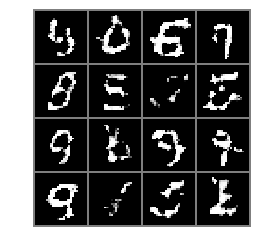

Epochs : 40 : DIS_COST  1.027545192639033       || GEN_COST  1.5117060046394666
Epochs : 50 : DIS_COST  1.0529924835761388       || GEN_COST  1.434250940879186
Epochs : 60 : DIS_COST  1.046879777610302       || GEN_COST  1.4639998512466748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


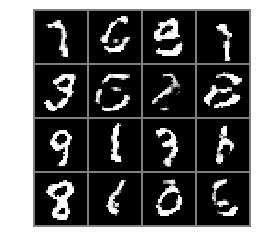

Epochs : 70 : DIS_COST  1.0358819234371186       || GEN_COST  1.5242362423737843
Epochs : 80 : DIS_COST  1.009316274523735       || GEN_COST  1.5683271251122157
Epochs : 90 : DIS_COST  1.0213778971632321       || GEN_COST  1.541993320186933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


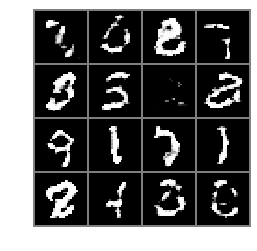

Epochs : 100 : DIS_COST  1.0064580722649892       || GEN_COST  1.5982375879089037
Epochs : 110 : DIS_COST  0.9880738318959872       || GEN_COST  1.609813762307167
Epochs : 120 : DIS_COST  0.9967587556441625       || GEN_COST  1.6233894030253093


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


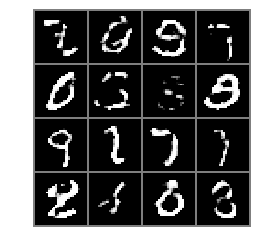

Epochs : 130 : DIS_COST  0.9780717143416404       || GEN_COST  1.6521412047743798
Epochs : 140 : DIS_COST  0.9858801220854123       || GEN_COST  1.6439091976483662
Epochs : 150 : DIS_COST  0.9948871963222822       || GEN_COST  1.6414345008134843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


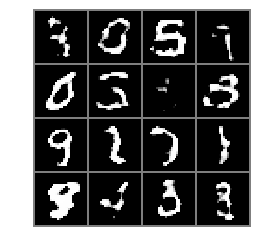

Epochs : 160 : DIS_COST  0.9882751301924387       || GEN_COST  1.6539310030142467
Epochs : 170 : DIS_COST  0.9708003122607867       || GEN_COST  1.7118490572770437
Epochs : 180 : DIS_COST  0.9736463271578153       || GEN_COST  1.6900960916280747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


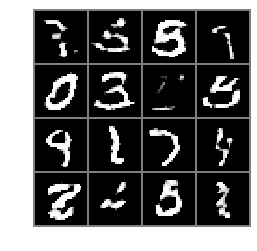

Epochs : 190 : DIS_COST  0.9651356234153112       || GEN_COST  1.704357189734777
Epochs : 200 : DIS_COST  0.9610895651578903       || GEN_COST  1.7439785369237264
Epochs : 210 : DIS_COST  0.958571996986866       || GEN_COST  1.752039922674497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


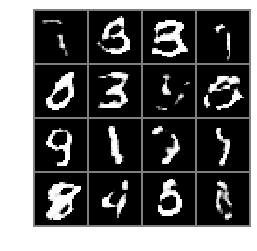

Epochs : 220 : DIS_COST  0.9487881783644359       || GEN_COST  1.781294586757819
Epochs : 230 : DIS_COST  0.9595719301700592       || GEN_COST  1.7370479721824328
Epochs : 240 : DIS_COST  0.9606636023521423       || GEN_COST  1.7347720474004746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


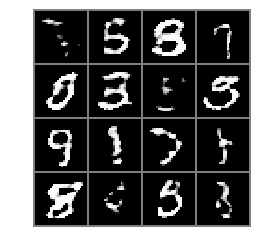

Epochs : 250 : DIS_COST  0.9482876906792322       || GEN_COST  1.7798097185293833
Epochs : 260 : DIS_COST  0.9549117044607798       || GEN_COST  1.747975107828776
Epochs : 270 : DIS_COST  0.9498837026953697       || GEN_COST  1.753950946331024


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


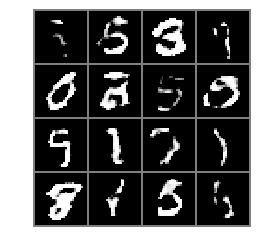

Epochs : 280 : DIS_COST  0.9535538243254026       || GEN_COST  1.7595786300301552
Epochs : 290 : DIS_COST  0.9434177229801813       || GEN_COST  1.7923441888888676
Epochs : 300 : DIS_COST  0.942185855905215       || GEN_COST  1.783977808157603


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


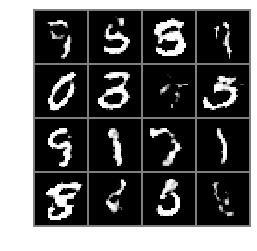

Epochs : 310 : DIS_COST  0.9559714795152346       || GEN_COST  1.7623642325401305
Epochs : 320 : DIS_COST  0.947289714217186       || GEN_COST  1.8063891371091207
Epochs : 330 : DIS_COST  0.9537781775991122       || GEN_COST  1.8004357675711313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


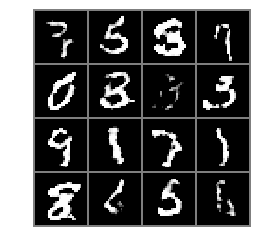

Epochs : 340 : DIS_COST  0.9429091135660808       || GEN_COST  1.8247671153148015
Epochs : 350 : DIS_COST  0.9541674217581749       || GEN_COST  1.7957457077503205
Epochs : 360 : DIS_COST  0.9453806696335475       || GEN_COST  1.812270537018776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


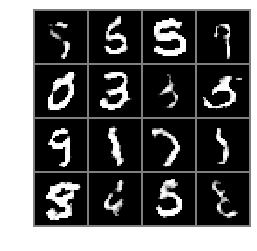

Epochs : 370 : DIS_COST  0.9460927192370097       || GEN_COST  1.8069122737646104
Epochs : 380 : DIS_COST  0.948742281794548       || GEN_COST  1.8058333017428716
Epochs : 390 : DIS_COST  0.9286610754330953       || GEN_COST  1.857454105814298


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


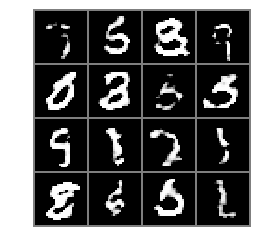

Epochs : 400 : DIS_COST  0.9366637349128724       || GEN_COST  1.8191872668266296
Epochs : 410 : DIS_COST  0.9412080485622089       || GEN_COST  1.812430449326833
Epochs : 420 : DIS_COST  0.9332768281300863       || GEN_COST  1.8362098465363184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


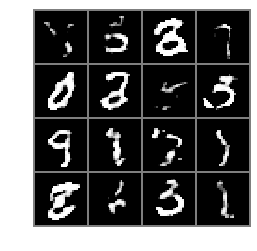

Epochs : 430 : DIS_COST  0.9443804184595744       || GEN_COST  1.8197170621156693
Epochs : 440 : DIS_COST  0.9349633075793584       || GEN_COST  1.8360958323876062
Epochs : 450 : DIS_COST  0.9405436778068542       || GEN_COST  1.81667670806249


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


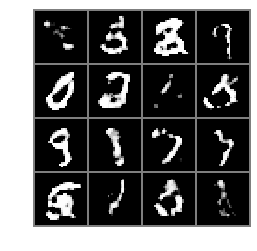

Epochs : 460 : DIS_COST  0.9308242167035738       || GEN_COST  1.8588873436053595
Epochs : 470 : DIS_COST  0.9394288287560145       || GEN_COST  1.8360559095939
Epochs : 480 : DIS_COST  0.940662080347538       || GEN_COST  1.816228869756063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


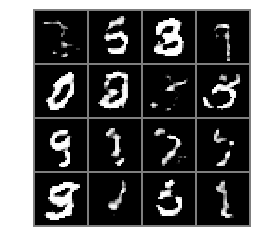

Epochs : 490 : DIS_COST  0.93312454611063       || GEN_COST  1.8474378969271978
Epochs : 500 : DIS_COST  0.9433901817599932       || GEN_COST  1.830530577103297
Epochs : 510 : DIS_COST  0.9422176499168078       || GEN_COST  1.8222716379165649


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


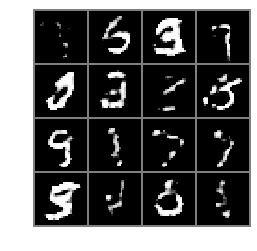

Epochs : 520 : DIS_COST  0.9391694197058678       || GEN_COST  1.8612172255913417
Epochs : 530 : DIS_COST  0.9276143523057302       || GEN_COST  1.8835165762901307
Epochs : 540 : DIS_COST  0.9401664071281751       || GEN_COST  1.8449090605974197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


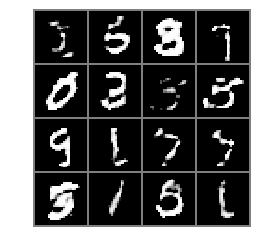

Epochs : 550 : DIS_COST  0.9428622864683469       || GEN_COST  1.8308101109663646
Epochs : 560 : DIS_COST  0.9496882848938306       || GEN_COST  1.8274899007876715
Epochs : 570 : DIS_COST  0.9400738281011581       || GEN_COST  1.8226297008991241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


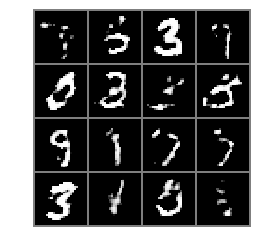

Epochs : 580 : DIS_COST  0.9363934702674548       || GEN_COST  1.8618776881694794
Epochs : 590 : DIS_COST  0.9578463300069173       || GEN_COST  1.7845329262812932
Epochs : 600 : DIS_COST  0.9475691525141398       || GEN_COST  1.819656359553337


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


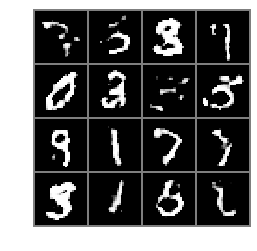

Epochs : 610 : DIS_COST  0.9505243569612503       || GEN_COST  1.8124051173528035
Epochs : 620 : DIS_COST  0.942743352651596       || GEN_COST  1.8304992405573528
Epochs : 630 : DIS_COST  0.9517815204461416       || GEN_COST  1.7979974084099133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


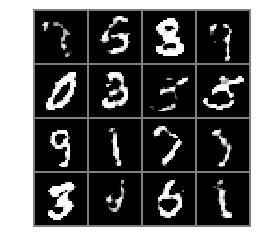

Epochs : 640 : DIS_COST  0.9263470479846001       || GEN_COST  1.843861307700475
Epochs : 650 : DIS_COST  0.947088463306427       || GEN_COST  1.819661769270897
Epochs : 660 : DIS_COST  0.9367272613445917       || GEN_COST  1.8348172482848168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


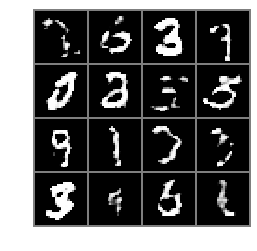

Epochs : 670 : DIS_COST  0.9328693560759227       || GEN_COST  1.8394090972344082
Epochs : 680 : DIS_COST  0.9323079268137614       || GEN_COST  1.8311692357063294
Epochs : 690 : DIS_COST  0.9449453400572141       || GEN_COST  1.801784506837527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


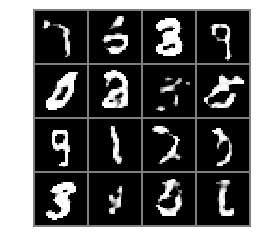

Epochs : 700 : DIS_COST  0.9311078891158104       || GEN_COST  1.862197170853615
Epochs : 710 : DIS_COST  0.9454407591621081       || GEN_COST  1.8064783672491709
Epochs : 720 : DIS_COST  0.940051157772541       || GEN_COST  1.8170324897766112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


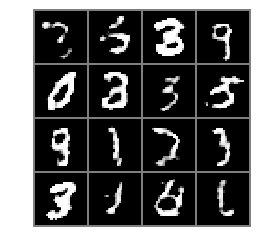

Epochs : 730 : DIS_COST  0.9360548801223437       || GEN_COST  1.833699160416921
Epochs : 740 : DIS_COST  0.9418941156069438       || GEN_COST  1.819496790667375
Epochs : 750 : DIS_COST  0.9434167561928432       || GEN_COST  1.7922675891717275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


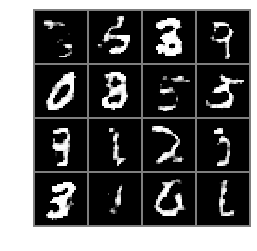

Epochs : 760 : DIS_COST  0.927585603694121       || GEN_COST  1.8454333482186
Epochs : 770 : DIS_COST  0.9343985556562742       || GEN_COST  1.8212789817651114
Epochs : 780 : DIS_COST  0.9350088555614153       || GEN_COST  1.8008191776275635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


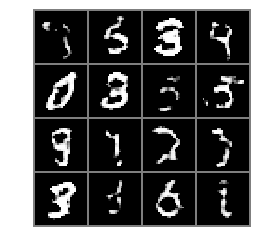

Epochs : 790 : DIS_COST  0.940216778020064       || GEN_COST  1.805734550654888
Epochs : 800 : DIS_COST  0.9406621237595876       || GEN_COST  1.8248250874876977
Epochs : 810 : DIS_COST  0.9411666253209114       || GEN_COST  1.8239417131741842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


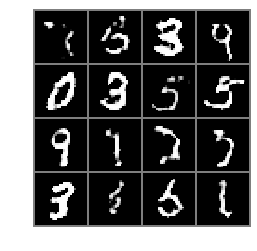

Epochs : 820 : DIS_COST  0.939475835164388       || GEN_COST  1.8125487571954728
Epochs : 830 : DIS_COST  0.941378416121006       || GEN_COST  1.7995575360457103
Epochs : 840 : DIS_COST  0.9280742497245471       || GEN_COST  1.8581472835938135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


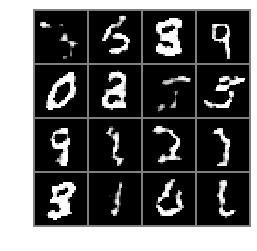

Epochs : 850 : DIS_COST  0.9352433771888415       || GEN_COST  1.8374920601646105
Epochs : 860 : DIS_COST  0.9384332146247228       || GEN_COST  1.8268184226751327
Epochs : 870 : DIS_COST  0.9415747206409772       || GEN_COST  1.8029254444440206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


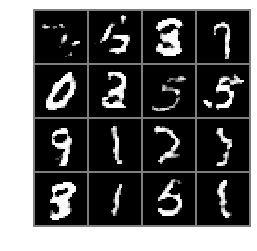

Epochs : 880 : DIS_COST  0.945586304863294       || GEN_COST  1.8059692652026813
Epochs : 890 : DIS_COST  0.9519753804802895       || GEN_COST  1.808994283080101
Epochs : 900 : DIS_COST  0.9473818642894427       || GEN_COST  1.7939786100387574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


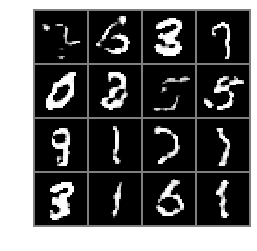

Epochs : 910 : DIS_COST  0.9293278081218401       || GEN_COST  1.8387992664178212
Epochs : 920 : DIS_COST  0.9312221522132555       || GEN_COST  1.8479213533798853
Epochs : 930 : DIS_COST  0.9375380634268125       || GEN_COST  1.820560210943222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


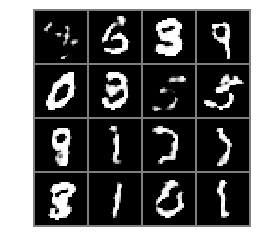

Epochs : 940 : DIS_COST  0.9385857627789179       || GEN_COST  1.824210392832756
Epochs : 950 : DIS_COST  0.941218309700489       || GEN_COST  1.8063395162423452
Epochs : 960 : DIS_COST  0.9305501380562782       || GEN_COST  1.8284339010715485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


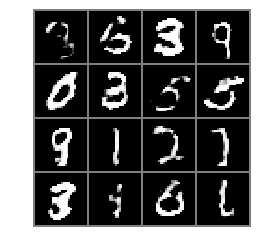

Epochs : 970 : DIS_COST  0.9233472074071566       || GEN_COST  1.8390964670976002
Epochs : 980 : DIS_COST  0.9325116130709649       || GEN_COST  1.79270466029644
Epochs : 990 : DIS_COST  0.9332019578417142       || GEN_COST  1.8293175558249155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


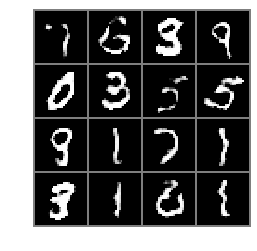

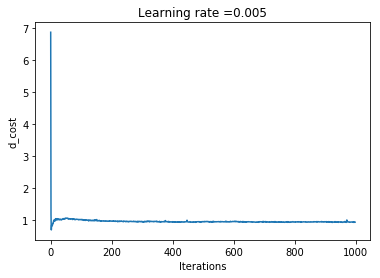

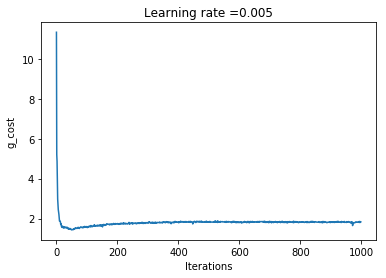

In [0]:
Gen_Imgs = model(X_train,epochs = 1000, minibatch_size = 100,learning_rate=0.0050)

# Testing

In [0]:
Z_f = np.random.uniform(-1,1, size=(16,100))

In [0]:
tst = generator(Z_f.astype(np.float32),16)

In [0]:
a = sess.run(tst)

In [0]:
a.shape

(16, 28, 28, 1)

In [0]:
a_grid = montage(a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


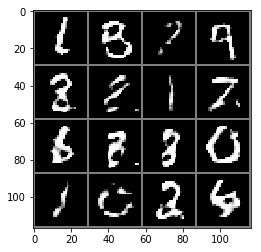

In [0]:
plt.imshow(a_grid)

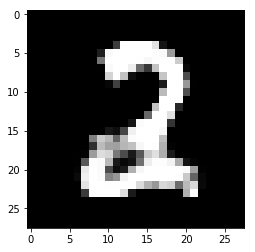

In [0]:
plt.imshow((a[14,:,:,0]),cmap="gray")

In [0]:
Gen_Imgs = np.array(Gen_Imgs)

In [0]:
len(Gen_Imgs)

999

In [0]:
from cv2 import VideoWriter, VideoWriter_fourcc
def make_video(images,fps=15):
    L = len(images)
    size = images[0].shape[1], images[0].shape[0]
    vid = VideoWriter('pathOut.mp4',VideoWriter_fourcc(*'MJPG'), fps, size)
    for i in range(0,L):
        img = images[i]
        vid.write(np.uint8(img))
    vid.release()
    return vid

In [0]:
video = make_video(Gen_Imgs,fps=15)

In [0]:
video

<VideoWriter 0x7f486ffd4c10>